# Preprocessing Forex data

In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
import matplotlib.pyplot as plt
import pickle

# Load the data
data = pd.read_csv('EURUSD_data')  # Replace with your file path

# Select features and target
features = data[['Open', 'High', 'Low', 'Close', 'Adj Close']]
target = data['Close']

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

# Create sequences of data for CNN + LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # Use the 'Close' price as target
    return np.array(X), np.array(y)

seq_length = 60  # Using 60 days of data to predict the next day's price
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Applying CNN 

In [17]:
# Initialize the model
model = Sequential()

# 1D Convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))


# Building LSTM Model

In [29]:

# Initialize the model
model = Sequential()

# GRU layer 1
model.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# GRU layer 2
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 60, 100)           32100     
                                                                 
 dropout_10 (Dropout)        (None, 60, 100)           0         
                                                                 
 gru_7 (GRU)                 (None, 50)                22800     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 54951 (214.65 KB)
Trainable params: 54951 (214.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training the model

In [30]:
# Train the model
history = model.fit(X_train, y_train, epochs=120, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/120
64/64 [==============================] - 5s 48ms/step - loss: 0.0267 - val_loss: 9.9720e-04
Epoch 2/120
64/64 [==============================] - 2s 36ms/step - loss: 0.0030 - val_loss: 3.4351e-04
Epoch 3/120
64/64 [==============================] - 2s 37ms/step - loss: 0.0025 - val_loss: 3.0314e-04
Epoch 4/120
64/64 [==============================] - 2s 37ms/step - loss: 0.0024 - val_loss: 3.1303e-04
Epoch 5/120
64/64 [==============================] - 2s 38ms/step - loss: 0.0021 - val_loss: 2.9029e-04
Epoch 6/120
64/64 [==============================] - 2s 39ms/step - loss: 0.0023 - val_loss: 2.8428e-04
Epoch 7/120
64/64 [==============================] - 2s 39ms/step - loss: 0.0019 - val_loss: 2.7704e-04
Epoch 8/120
64/64 [==============================] - 2s 37ms/step - loss: 0.0019 - val_loss: 3.1852e-04
Epoch 9/120
64/64 [==============================] - 2s 35ms/step - loss: 0.0017 - val_loss: 2.8284e-04
Epoch 10/120
64/64 [==============================] - 2s 37ms/st

# Saving the model

In [31]:
# Save the model to a pickle file
with open('gru.pkl', 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved as cnn_lstm_model.pkl")

Model saved as cnn_lstm_model.pkl


# Model Evaluation

### 1. Numerical

In [32]:
# Predicting on test data
predicted_prices = model.predict(X_test)

# Inverse transform the predicted and actual values to get them in the original scale
predicted_prices = scaler.inverse_transform(np.concatenate([X_test[:, -1, :-1], predicted_prices], axis=1))[:, -1]
actual_prices = scaler.inverse_transform(np.concatenate([X_test[:, -1, :-1], y_test.reshape(-1, 1)], axis=1))[:, -1]

# Evaluate the model
mse = np.mean((predicted_prices - actual_prices) ** 2)
print(f"Mean Squared Error: {mse}")

16/16 [==============================] - 2s 11ms/step
Mean Squared Error: 1.296775252170859e-05


### 2. Graphical

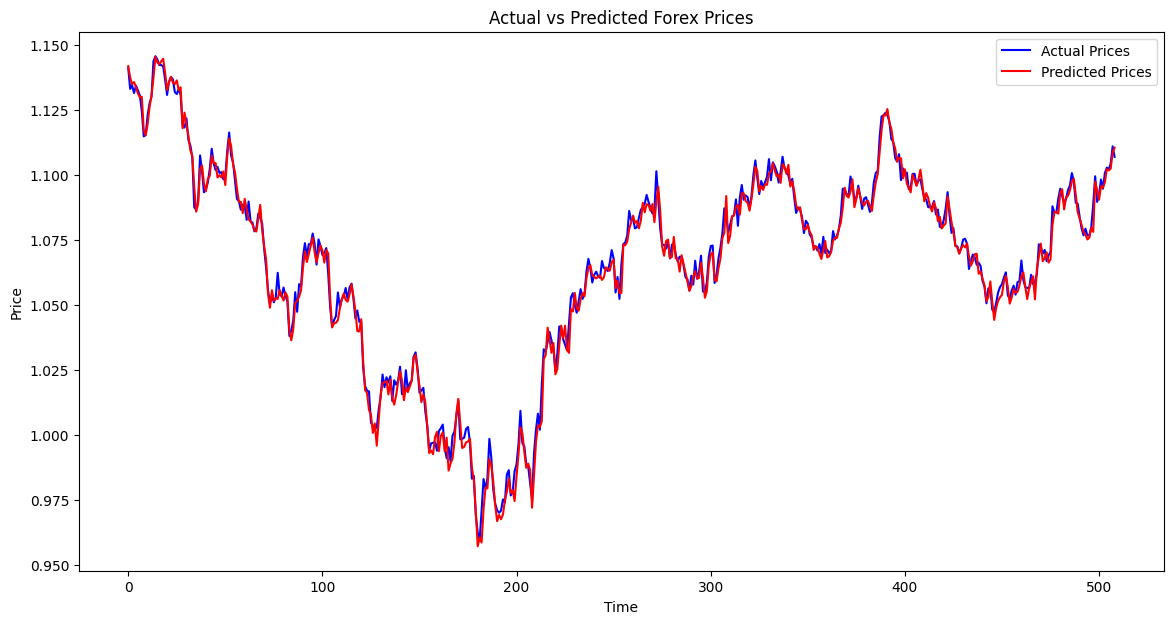

In [33]:
# Plot the actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.title('Actual vs Predicted Forex Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()